In [1]:
import os
from glob import glob
import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm 

In [2]:
risultati = [y for x in os.walk("final_joined_result/") for y in glob(os.path.join(x[0], '*.csv'))]
risultati[:5]

['final_joined_result\\2d-20c-no0_y.zip CenterParTree2.csv',
 'final_joined_result\\2d-20c-no0_y.zip ImpurityParTree2.csv',
 'final_joined_result\\2d-20c-no0_y.zip kmodes.csv',
 'final_joined_result\\2d-20c-no0_y.zip PrincipalParTree.csv',
 'final_joined_result\\2d-20c-no0_y.zip pyc_agglomerativeClust.csv']

In [3]:
risultati_groupby_alg = dict()
risultati_groupby_dataset = dict()

for filename in risultati:
    alg = filename.split(" ")[-1][:-4]
    dataset = filename.split(" ")[0].split("\\")[-1][:-4]
    
    if alg not in risultati_groupby_alg:
        risultati_groupby_alg[alg] = []
    if dataset not in risultati_groupby_dataset:
        risultati_groupby_dataset[dataset] = []
    
    risultati_groupby_alg[alg].append(filename)
    risultati_groupby_dataset[dataset].append(filename)

In [4]:
res_values_uns = ["time", "silhouette", "calinski_harabasz", "davies_bouldin"]
res_values_sup = ["r_score", "adj_rand", "mut_info_score", "adj_mutual_info_score", "norm_mutual_info_score",
                                 "homog_score", "complete_score", "v_msr_score", "fwlks_mallows_score"]
res_values_all = res_values_uns + res_values_sup

In [7]:
df = pd.DataFrame()
lista = []

datasets = set()
algorithms = set()

for filename in risultati:
    alg = filename.split(" ")[-1][:-4]
    dataset = filename.split(" ")[0].split("\\")[-1][:-4].replace(".zip", "").replace("-", "")
    
    datasets.add(dataset)
    algorithms.add(alg)
    
    lista.append(pd.read_csv(filename))
    
    lista[-1]["alg"] = alg
    if "wine" in dataset:
        lista[-1]["dataset"] = "wine"
    elif "home" in dataset:
        lista[-1]["dataset"] = "home"
    else:
        lista[-1]["dataset"] = dataset.split("_y")[0]+"_y"
    
df = pd.concat(lista)

df.columns

Index(['max_depth', 'max_nbr_clusters', 'min_samples_leaf',
       'min_samples_split', 'max_nbr_values', 'max_nbr_values_cat', 'bic_eps',
       'random_state', 'metric_con', 'metric_cat', 'time', 'silhouette',
       'calinski_harabasz', 'davies_bouldin', 'r_score', 'adj_rand',
       'mut_info_score', 'adj_mutual_info_score', 'norm_mutual_info_score',
       'homog_score', 'complete_score', 'v_msr_score', 'fwlks_mallows_score',
       'alg', 'dataset', 'criteria_clf', 'criteria_reg', 'n_clusters',
       'max_iter', 'init', 'n_init', 'verbose', 'n_jobs', 'n_components',
       'oblique_splits', 'max_oblique_features', 'number_clusters',
       'amount_initial_centers', 'kmax', 'metric', 'linkage', 'threshold',
       'branching_factor', 'eps', 'min_samples', 'algorithm', 'max_eps', 'tol',
       'copy', 'bisecting_strategy', 'labels_as_tree_leaves', 'criterion',
       'splitter', 'min_weight_fraction_leaf', 'max_features',
       'max_leaf_nodes', 'min_impurity_decrease', 'class_we

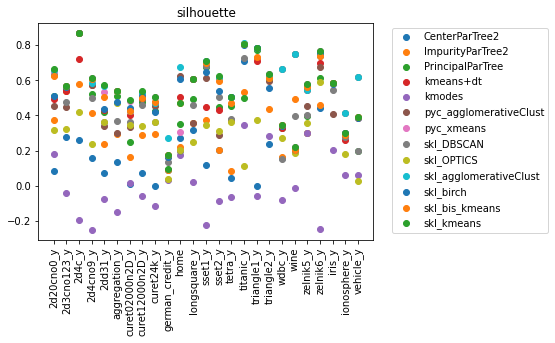

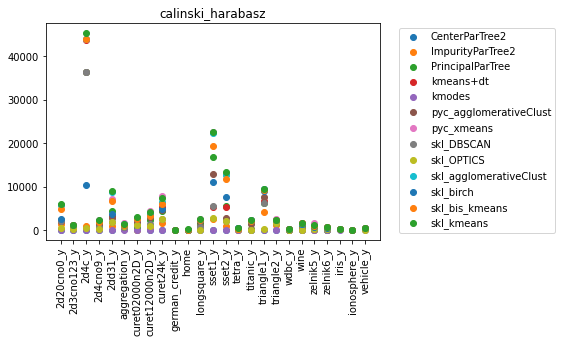

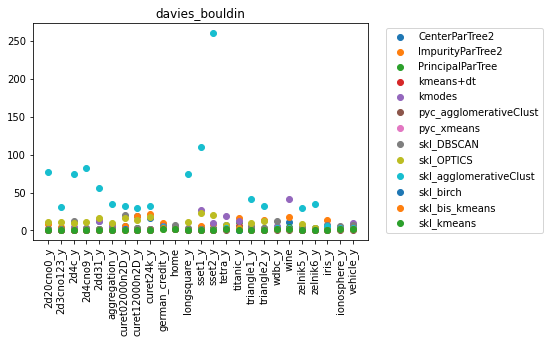

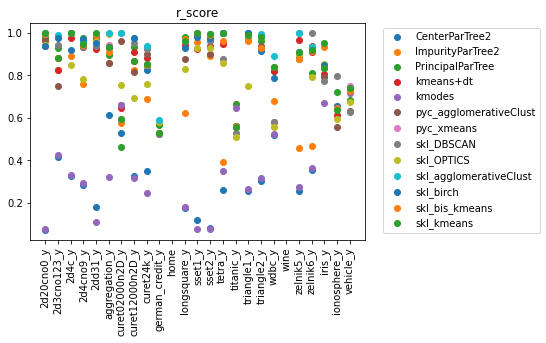

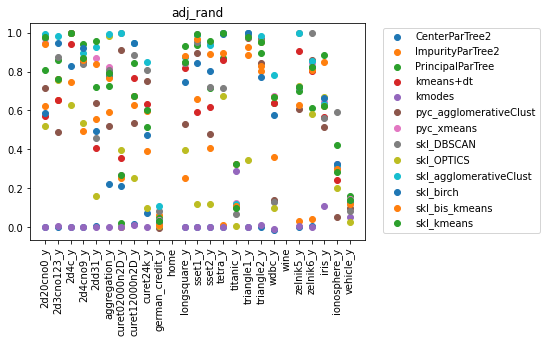

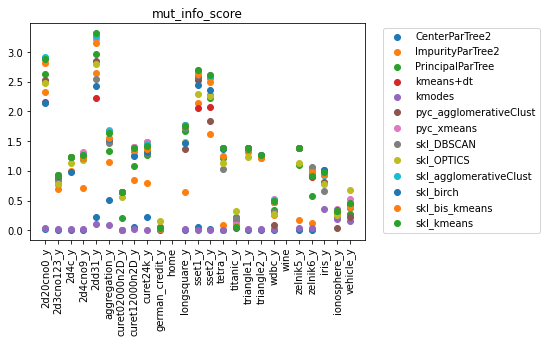

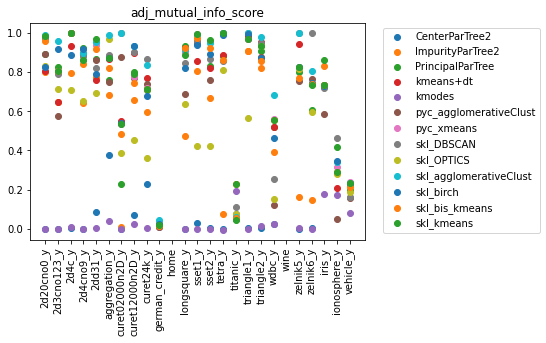

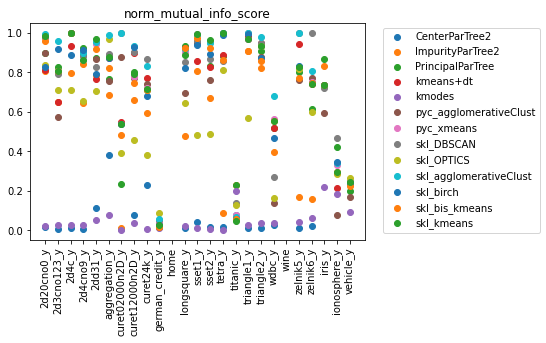

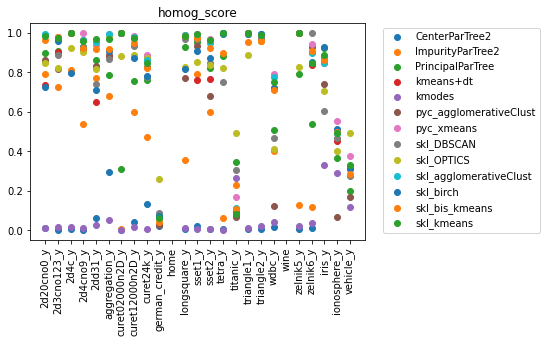

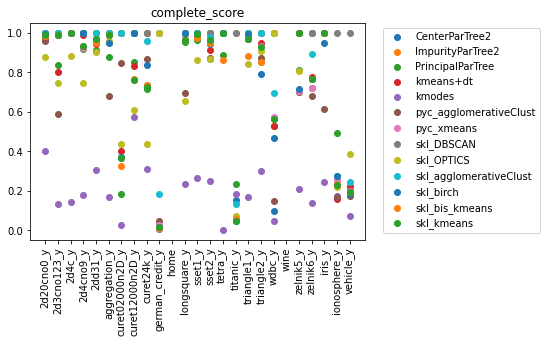

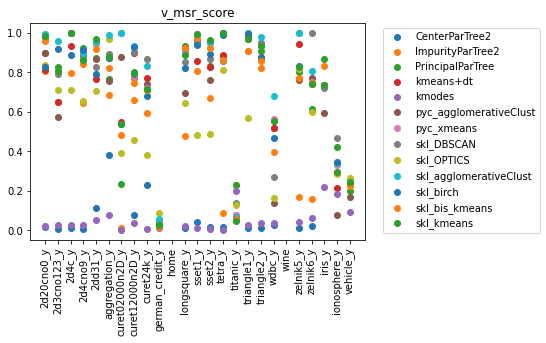

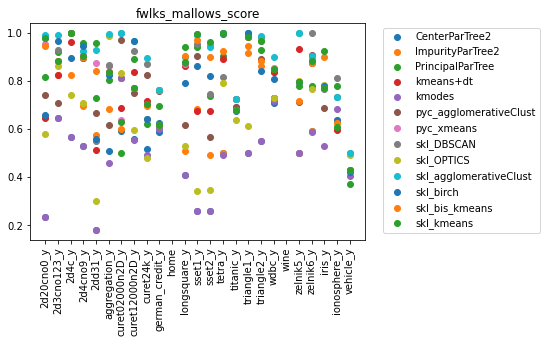

In [8]:
for col in res_values_all:
    if col == "time":
        continue

    df_plot = df.groupby(by=["dataset", "alg"])[[col, "time"]].max().reset_index()
    
    #df_plot = df_plot[df_plot.alg.isin(algoritmi_grafico)]

    for alg in df_plot.alg.unique():
        plt.scatter(df_plot[df_plot.alg == alg].dataset, 
                    df_plot[df_plot.alg == alg][col], 
                    label=alg, 
                    #s=df_plot[df_plot.alg == alg].time
                   )

    plt.title(col)

    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

    plt.xticks(rotation=90)

    plt.show()

In [24]:
idx = df.groupby(['dataset', 'alg'])['silhouette'].transform(max) == df['silhouette']

In [28]:
df.loc[idx][['dataset', 'alg', 'silhouette']]

,dataset,alg,silhouette
217,2d20cno0_y,CenterParTree2,0.0816
218,2d20cno0_y,CenterParTree2,0.0816
220,2d20cno0_y,CenterParTree2,0.0816
221,2d20cno0_y,CenterParTree2,0.0816
229,2d20cno0_y,CenterParTree2,0.0816
...,...,...,...
1,zelnik6_y,skl_kmeans,0.7648
2,zelnik6_y,skl_kmeans,0.7648
3,zelnik6_y,kmeans+dt,0.6979
7,zelnik6_y,kmeans+dt,0.6979


In [46]:
df_subset_list = []

for dataset, alg, silhouette in tqdm(df.groupby(['dataset', 'alg'])['silhouette'].max().reset_index().values):
    df_subset = df[(df.dataset == dataset) & (df.alg == alg) & (df.silhouette == silhouette)]
    df_subset = df_subset.sort_values(by=res_values_uns).head(1)
    df_subset_list.append(df_subset)

df_subset = pd.concat(df_subset_list)
df_subset[["silhouette", "alg", "dataset"]].head()

  0%|          | 0/320 [00:00<?, ?it/s]

,silhouette,alg,dataset
256,0.0816,CenterParTree2,2d20cno0_y
29646,0.3746,ImpurityParTree2,2d20cno0_y
21468,0.5090,PrincipalParTree,2d20cno0_y
7,0.4926,kmeans+dt,2d20cno0_y
11,0.1823,kmodes,2d20cno0_y


In [87]:
df_subset["rank_per_dataset"] = df_subset.groupby("dataset")["silhouette"].rank(ascending=False).astype(int)

df_subset.sort_values(["dataset", "rank_per_dataset"])[["rank_per_dataset", "silhouette", "alg", "dataset"]]

,rank_per_dataset,silhouette,alg,dataset
0,1,0.6613,skl_kmeans,2d20cno0_y
29,2,0.6578,skl_agglomerativeClust,2d20cno0_y
10,3,0.6479,pyc_xmeans,2d20cno0_y
8,4,0.6268,skl_DBSCAN,2d20cno0_y
4,5,0.6218,skl_bis_kmeans,2d20cno0_y
...,...,...,...,...
736,9,0.6111,PrincipalParTree,zelnik6_y
9,10,0.5909,skl_OPTICS,zelnik6_y
734,11,0.4560,ImpurityParTree2,zelnik6_y
727,12,0.4394,CenterParTree2,zelnik6_y


In [140]:
df_agg = df_subset.groupby("alg")[res_values_all].agg(["mean", "std"])

df_agg.head()

time            silhouette           calinski_harabasz  \
                      mean        std       mean       std              mean   
alg                                                                            
CenterParTree2    8.916268  16.370456   0.213800  0.204111         25.778718   
ImpurityParTree2  4.086572  10.198340   0.356513  0.169873        707.006304   
PrincipalParTree  0.105480   0.188031   0.461332  0.178022       3563.594712   
kmeans+dt         0.265222   0.359807   0.493260  0.158652       3168.511152   
kmodes            0.191118   0.235234   0.000452  0.168881         10.513028   

                              davies_bouldin             r_score            \
                          std           mean       std      mean       std   
alg                                                                          
CenterParTree2      51.141874       1.586809  2.355050  0.310665  0.184085   
ImpurityParTree2   994.415916       1.222004  0.811030  0.655357  0.251400   
PrincipalParTree  7681.248944       1.140276  0.834677  0.826957  0.162586   
kmeans+dt         6695.722704       0.844380  0.443590  0.773974  0.151591   
kmodes              19.233783       3.252560  3.781066  0.323548  0.184327   

                  ... norm_mutual_info_score           homog_score            \
                  ...                   mean       std        mean       std   
alg               ...                                                          
CenterParTree2    ...               0.025345  0.083698    0.016730  0.058509   
ImpurityParTree2  ...               0.433605  0.328226    0.388776  0.321866   
PrincipalParTree  ...               0.647670  0.306452    0.624035  0.306226   
kmeans+dt         ...               0.592130  0.281759    0.555978  0.309995   
kmodes            ...               0.022804  0.049381    0.017835  0.041340   

                 complete_score           v_msr_score            \
                           mean       std        mean       std   
alg                                                               
CenterParTree2         0.293145  0.283145    0.025345  0.083698   
ImpurityParTree2       0.572890  0.327548    0.433605  0.328226   
PrincipalParTree       0.685526  0.316080    0.647670  0.306452   
kmeans+dt              0.707030  0.332527    0.592130  0.281759   
kmodes                 0.183613  0.129367    0.022804  0.049381   

                 fwlks_mallows_score            
                                mean       std  
alg                                             
CenterParTree2              0.503100  0.167325  
ImpurityParTree2            0.649414  0.170277  
PrincipalParTree            0.761948  0.154170  
kmeans+dt                   0.688830  0.182457  
kmodes                      0.505665  0.161468  

[5 rows x 26 columns]

In [141]:
df_subset.groupby("alg")[["rank_per_dataset"]].agg(
    total=("rank_per_dataset", len),
    rank_list=("rank_per_dataset", lambda x: len(x[x == 1]))
)

,total,rank_list
alg,,
CenterParTree2,22,0
ImpurityParTree2,23,0
PrincipalParTree,25,0
kmeans+dt,25,0
kmodes,25,0
pyc_agglomerativeClust,25,3
pyc_xmeans,25,7
skl_DBSCAN,25,0
skl_OPTICS,25,0


In [145]:
dfs_win = []

metriche = dict([#Ascending?
    ('silhouette', False), #max
    ('time', True), #min
    ('calinski_harabasz', False),
    ('davies_bouldin', True),
    ('r_score', False),
    ('adj_rand', False),
    ('mut_info_score', False),
    ('adj_mutual_info_score', False),
    ('norm_mutual_info_score', False),
    ('homog_score', True),
    ('complete_score', False),
    ('v_msr_score', False),
    ('fwlks_mallows_score', False)
])

def getWin(metrica):
    ascending = metriche[metrica]
    df_tmp = df_subset[["alg", "dataset", metrica]].copy()
    df_tmp["rank"] = df_subset.groupby("dataset")[metrica].rank(ascending=ascending, na_option="top" if ascending else "bottom").astype(int)
    
    dfs_win.append(df_tmp)
    
    #print(metrica)
    print(df_tmp.sort_values(["dataset", metrica], ascending=ascending)[[metrica, "rank"]].head())
    
    return df_tmp.groupby("alg")[["rank"]].agg(
        c=("rank", len),
        win=("rank", lambda x: len(x[x == 1]))
    )

In [146]:
for metrica in res_values_all:
    df_tmp = getWin(metrica)
    df_agg[(metrica, "win")] = df_tmp.win
    df_agg[(metrica, "c")] = df_tmp.c

df_agg[df_agg.columns.sort_values()]

        time  rank
8   0.007109     1
10  0.019882     2
3   0.022105     3
29  0.027853     4
7   0.044187     5
    silhouette  rank
22      0.7648     1
1       0.7648     1
44      0.7560     3
4       0.7543     4
26      0.7383     5
    calinski_harabasz  rank
22           641.7966     1
1            641.7966     1
4            576.4192     3
44           573.9990     4
4            465.1163     5
    davies_bouldin  rank
0           0.4755     1
29          0.4773     2
10          0.5121     3
3           0.6226     4
4           0.6270     5
    r_score  rank
26   0.9152     1
44   0.9115     2
4    0.9034     3
22   0.8981     4
1    0.8981     4
    adj_rand  rank
26    0.8130     1
44    0.8065     2
4     0.7896     3
22    0.7787     4
1     0.7787     4
    mut_info_score  rank
26          0.8720     1
44          0.8507     2
7           0.8212     3
4           0.8212     3
22          0.8077     5
    adj_mutual_info_score  rank
44                 0.7640     1
26    

adj_mutual_info_score                         adj_rand  \
                                           c      mean       std win        c   
alg                                                                             
CenterParTree2                            22  0.021370  0.083827   0       22   
ImpurityParTree2                          23  0.430043  0.329785   1       23   
PrincipalParTree                          25  0.646091  0.306450   1       25   
kmeans+dt                                 25  0.590691  0.281880   1       25   
kmodes                                    25  0.020161  0.049076   1       25   
pyc_agglomerativeClust                    25  0.588904  0.362672   0       25   
pyc_xmeans                                25  0.692613  0.315964   1       25   
skl_DBSCAN                                25  0.632178  0.367141   2       25   
skl_OPTICS                                25  0.426426  0.288677   1       25   
skl_agglomerativeClust                    25  0.660813  0.384988   6       25   
skl_birch                                 25  0.674757  0.306695   3       25   
skl_bis_kmeans                            25  0.667300  0.303052   0       25   
skl_kmeans                                25  0.697013  0.317031   3       25   

                                               calinski_harabasz               \
                            mean       std win                 c         mean   
alg                                                                             
CenterParTree2          0.011640  0.049427   0                22    25.778718   
ImpurityParTree2        0.355357  0.307970   1                23   707.006304   
PrincipalParTree        0.592539  0.310769   2                25  3563.594712   
kmeans+dt               0.484587  0.300083   0                25  3168.511152   
kmodes                  0.021357  0.060164   1                25    10.513028   
pyc_agglomerativeClust  0.502939  0.357376   0                25  3158.180104   
pyc_xmeans              0.628330  0.340932   1                25  4792.732360   
skl_DBSCAN              0.571461  0.388970   4                25  2595.893148   
skl_OPTICS              0.309248  0.310184   1                25   672.654764   
skl_agglomerativeClust  0.613122  0.393006   5                25  4583.327836   
skl_birch               0.594009  0.317419   3                25  2674.302180   
skl_bis_kmeans          0.626048  0.312794   0                25  4521.369744   
skl_kmeans              0.634900  0.344442   3                25  4915.151276   

                        ... silhouette     time                            \
                        ...        std win    c       mean        std win   
alg                     ...                                                 
CenterParTree2          ...   0.204111   0   22   8.916268  16.370456   0   
ImpurityParTree2        ...   0.169873   0   23   4.086572  10.198340   0   
PrincipalParTree        ...   0.178022   0   25   0.105480   0.188031   0   
kmeans+dt               ...   0.158652   0   25   0.265222   0.359807   2   
kmodes                  ...   0.168881   0   25   0.191118   0.235234   0   
pyc_agglomerativeClust  ...   0.179516   3   25  23.045498  80.405025   0   
pyc_xmeans              ...   0.179891   7   25   0.016537   0.016517   4   
skl_DBSCAN              ...   0.199392   0   25   0.043373   0.120766   9   
skl_OPTICS              ...   0.151114   0   25   4.536635   4.587353   0   
skl_agglomerativeClust  ...   0.135101   8   25   0.070636   0.134891  10   
skl_birch               ...   0.173537   1   25   0.062001   0.167287   0   
skl_bis_kmeans          ...   0.171443   0   25   0.290294   0.359277   0   
skl_kmeans              ...   0.174203  10   25   0.276150   0.359372   0   

                       v_msr_score                          
                                 c      mean       std win  
alg                                                         
CenterParTree